In [15]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import numpy as np
import scipy.sparse as sp
from scanpy.external.pp import mnn_correct
from combat.pycombat import pycombat
import scanorama
from glob import glob
from collections import Counter
import seaborn as sns

# Read data

In [7]:
files = sorted(glob('../data/samples/*.h5ad'))
# Load AnnData objects
adata_list = [sc.read_h5ad(file) for file in files]
sample_names = ['Sample 1 - 40 nm NPs', 'Sample 2 - 200 nm NPs', 'Sample 3 - 40 + 200 nm NPs', 'Sample 4 - control']
for adata in adata_list:
    adata.var.set_index('var.festures', inplace=True)


In [9]:
samples = []
for i, adata in enumerate(adata_list):
    sample = f'sample_{i+1}'
    adata.obs['sample'] = sample # Add a column 'sample' to keep track of the sample source
    adata.obs.index = [f"{f'sample_{i+1}'}_{x}" for x in adata.obs.index]  # Modify the index to be unique
    samples.append(sample)

# Step 2: Merge all AnnData objects
merged_adata = adata_list[0].concatenate(adata_list[1:], join='inner', index_unique=None)
merged_adata.write_h5ad('../data/merged.h5ad', compression='gzip')

/tmp/ipykernel_1484/4227131546.py:6: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  merged_adata = adata_list[0].concatenate(adata_list[1:], join='inner', index_unique=None)


# Cell annotation overview

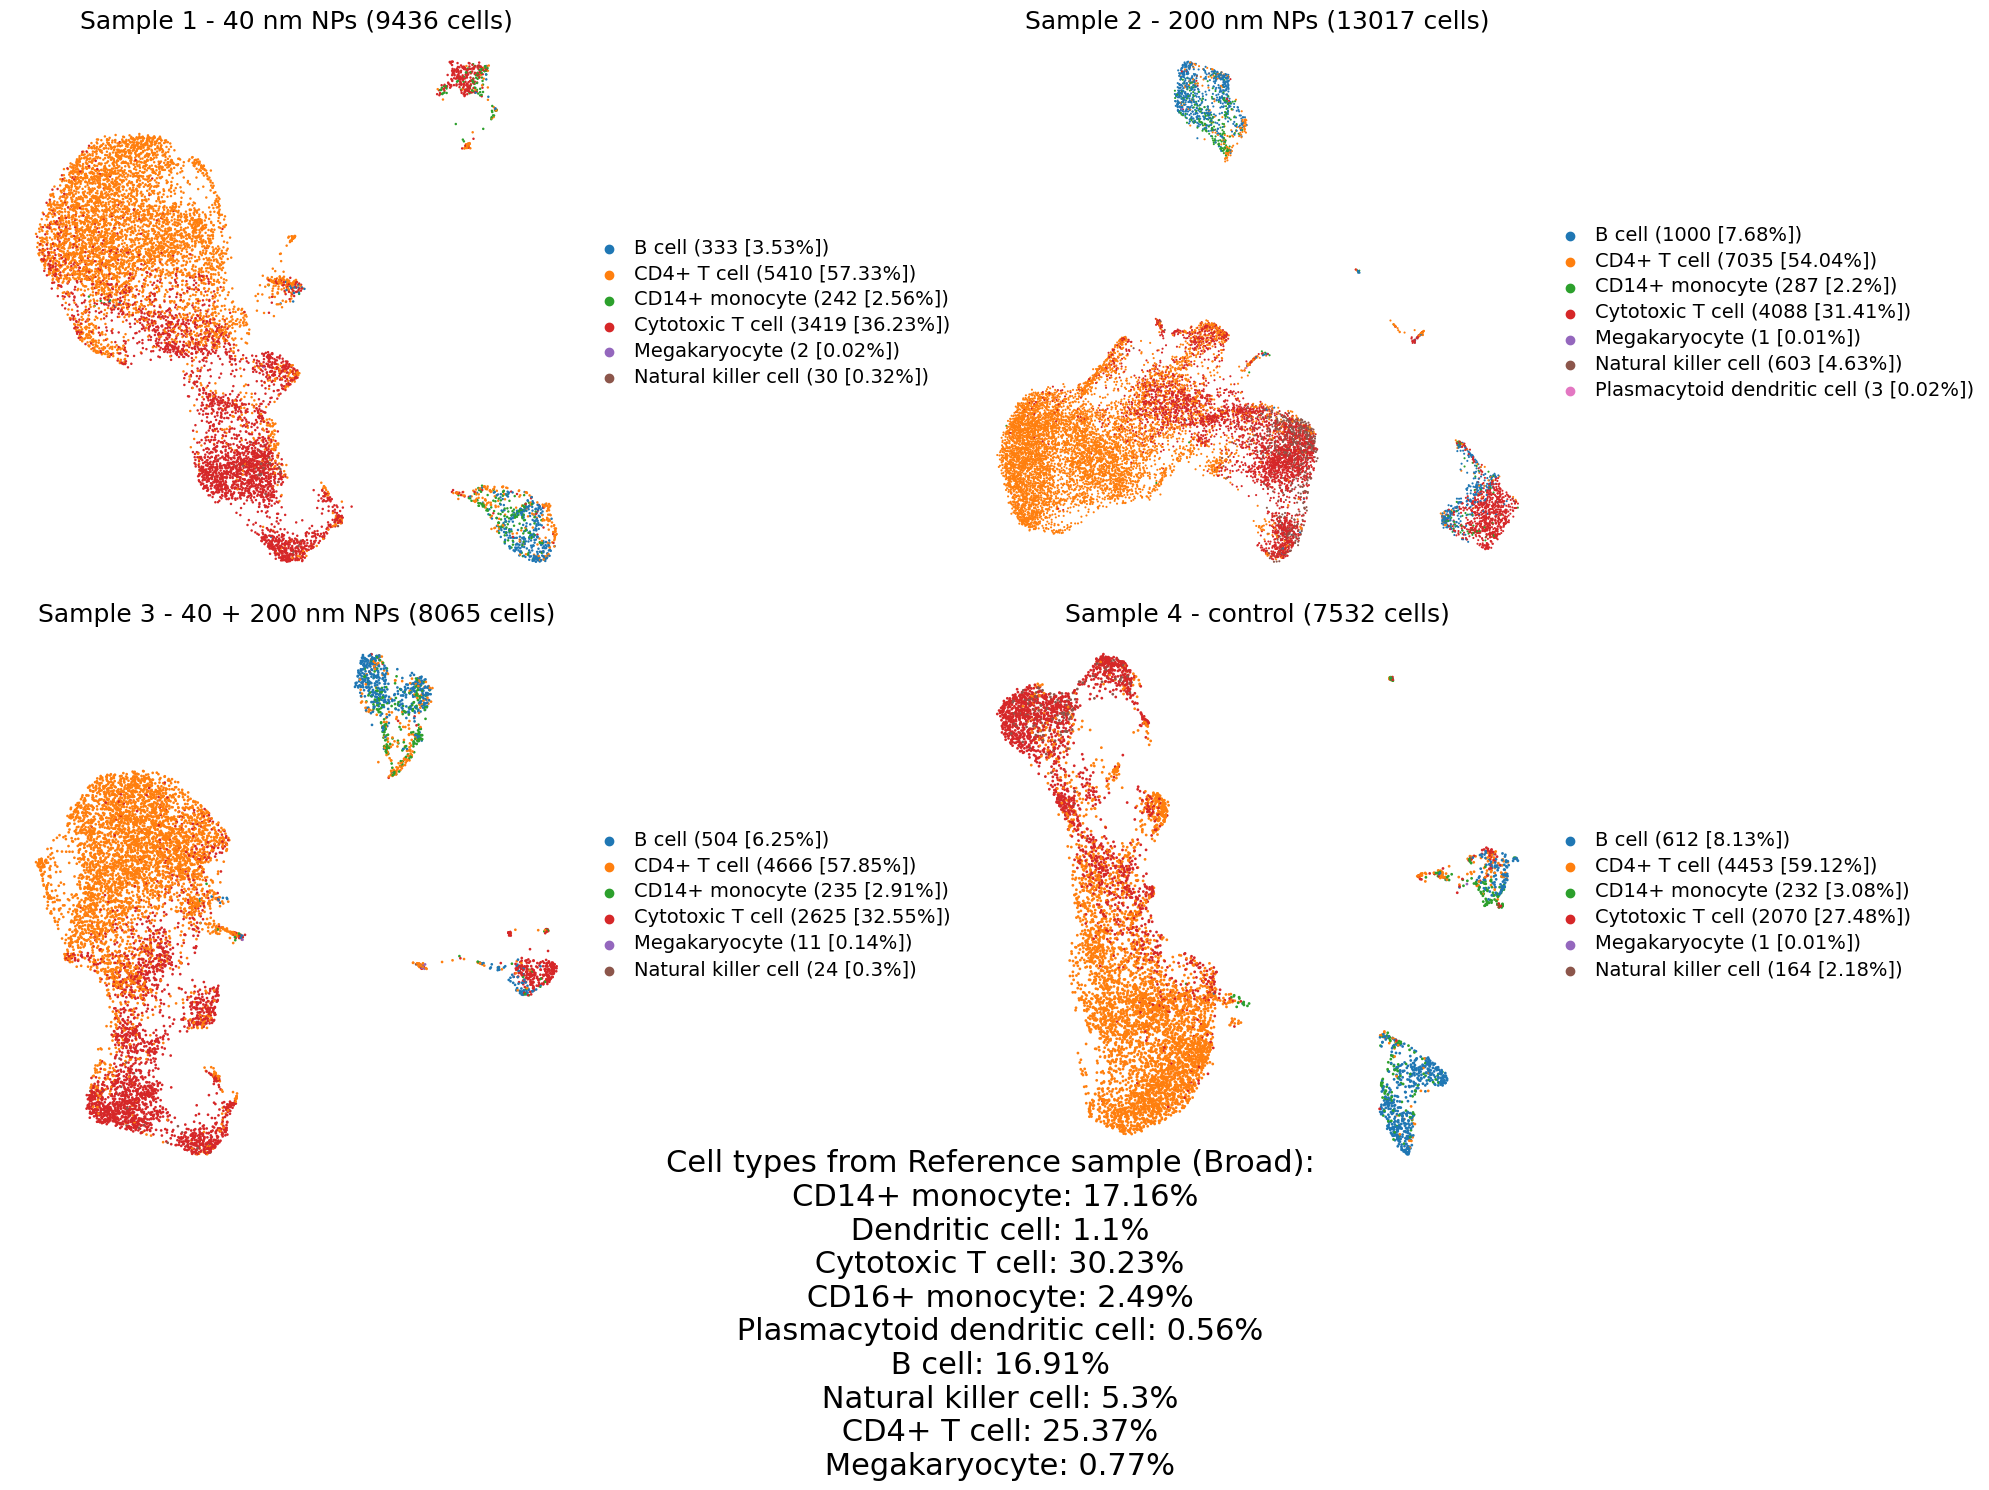

In [16]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()
cell_type_col = "predicted.celltype"  # Annotation column name
adata_ref = sc.read_h5ad('../data/ref_broad_pbmc/sc.h5ad')

for i, (adata, ax) in enumerate(zip(adata_list, axes)):
    # Calculate cell type counts and percentages

    cell_counts = adata.obs[cell_type_col].value_counts()
    total_cells = cell_counts.sum()
    percentages = (cell_counts / total_cells * 100).round(2)
    
    # Modify categories to include counts and percentages
    updated_categories = [
        f"{cell_type} ({count} [{percentage}%])"
        for cell_type, count, percentage in zip(cell_counts.index, cell_counts, percentages)
    ]
    mapping = dict(zip(cell_counts.index, updated_categories)) 
    adata.obs[cell_type_col + "_updated"] = adata.obs[cell_type_col].map(mapping)#.fillna("Unknown")
    
    # Plot UMAP
    sc.pl.umap(
        adata,
        color=cell_type_col + "_updated",
        ax=ax,
        show=False,
        title=sample_names[i],
        legend_loc="right margin"
    )
    ax.set_title(f'{sample_names[i]} ({len(adata)} cells)', size=18)
    # Remove frame around each subplot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    # Increase the legend font size
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_fontsize(14)  # Adjust the font size
    ax.set_xlabel(None)
    ax.set_ylabel(None)


# Add a horizontal legend at the bottom of the figure with reference cell types
# Define legend items and title
data = Counter(adata_ref.obs['CellType'])
total = sum(data.values())
# percentages = {key: np.round(value / total, 2) * 100 for key, value in data.items()}
legend_items = [f'{key}: {np.round(value / total * 100, 2)}' for key, value in data.items() if not str(key) in ['Unassigned', 'nan']]

fig.text(
    0.5, -0.1,  # Position: centered horizontally, slightly below the figure
    "Cell types from Reference sample (Broad): \n" + "%\n ".join(legend_items) + '%',  # Legend text
    ha='center', va='center', fontsize=22  # Alignment and font size
)

# Adjust layout and display
plt.tight_layout()
plt.savefig('nano2.png', dpi=150, bbox_inches='tight')
plt.show()


# Umap

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created PCA components in .obsm.X_pca


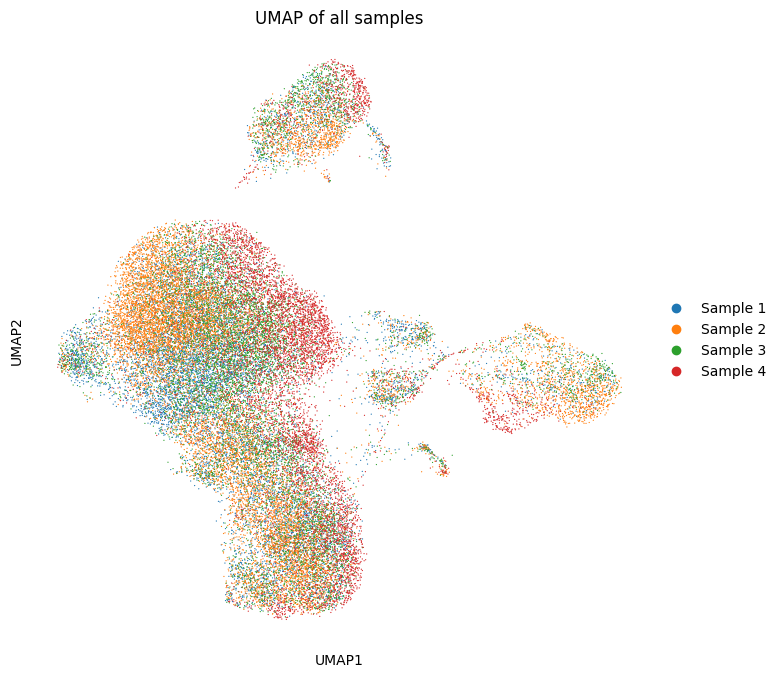

In [11]:
# merged_adata = sc.read_h5ad('../data/merged.h5ad')

def calc_umap(adata, use_rep="X_pca"):
    if use_rep == "X_pca":
        sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)  # Select top 2000 HVGs
        sc.pp.pca(adata, n_comps=50, use_highly_variable=True)
        sc.pp.neighbors(adata, n_pcs=50)
        sc.tl.umap(adata)

        print('Created PCA components in .obsm.X_pca')
    
    # Run neighbors and UMAP
    sc.pp.neighbors(adata, use_rep=use_rep, n_neighbors=15)  # Use PCA representation
    sc.tl.umap(adata)
    return adata

def plot_umap(adata):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Remove frame around each subplot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    sc.pl.umap(adata, color='sample', title='UMAP of all samples', show=False, ax=ax)
    # Modify legend labels to replace "_" with space
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_text(text.get_text().replace("sample", "Sample").replace("_", " "))
    plt.show()


    
adata_umap = calc_umap(merged_adata.copy())
plot_umap(adata_umap)
# adata_umap.write_h5ad('merged_umap.h5ad', compression='gzip')

# Batch effects correction - pycombat

In [4]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

# before = adata_combined.X.copy()
# sc.pp.combat(adata_combined, key='sample', inplace=True)

df_expression = pd.DataFrame(adata_combined.X.toarray(), index=adata_combined.obs.index, columns=adata_combined.var.index).T
# run pyComBat
df_corrected = pycombat(df_expression, adata_combined.obs['sample'].values)


# after = df_corrected
# print((before != after).sum())  # Count changes


Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created PCA components in .obsm.X_pca


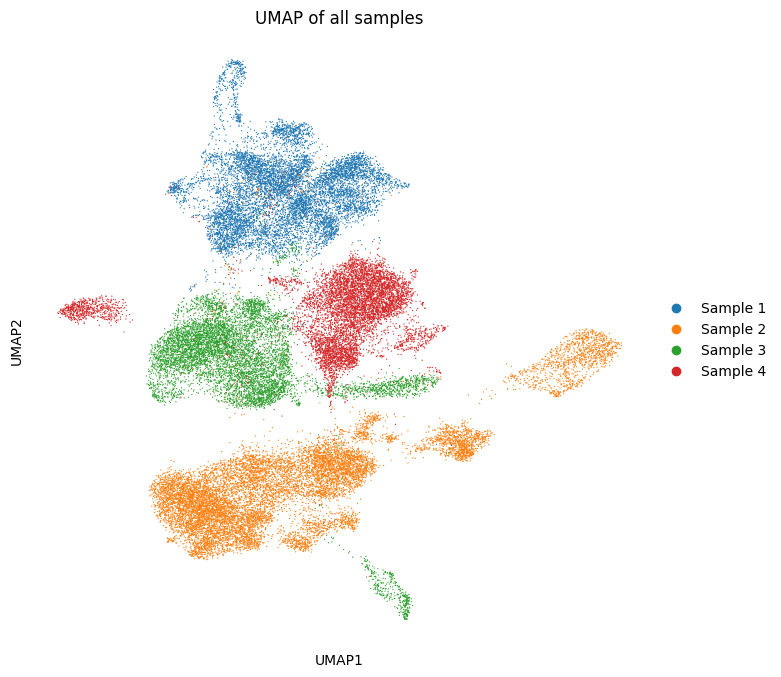

In [7]:
adata_corrected = adata_combined.copy()
adata_corrected.X = df_corrected.T.values
adata_corr_umap = calc_umap(adata_corrected)
plot_umap(adata_corr_umap)

# Batch effects correction - scanpy pycombat x4

837100000


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


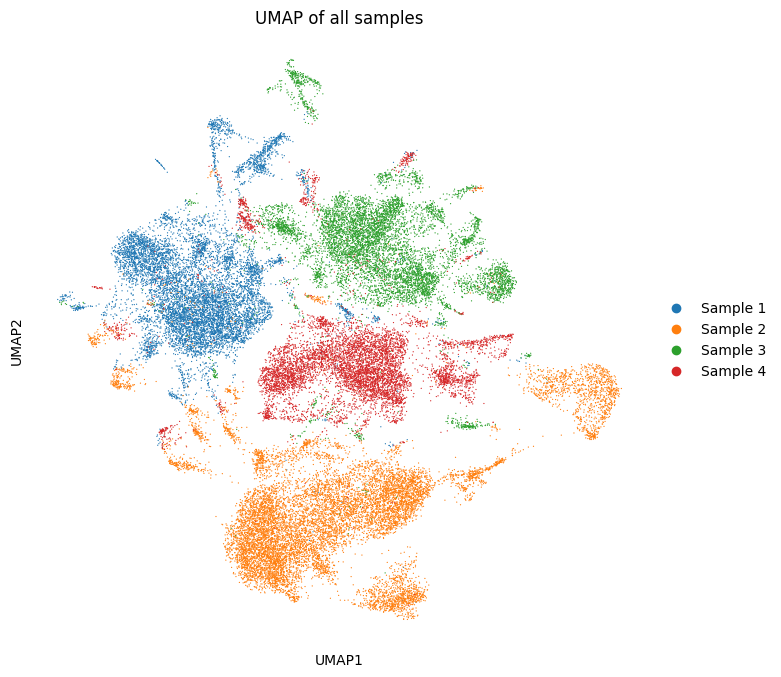

In [23]:
# 4 times

adata_combined = sc.read_h5ad('../data/merged.h5ad')
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X.copy()
for i in range(4):
    sc.pp.combat(adata_combined, key='sample', inplace=True)
after = adata_combined.X
print((before != after).sum())  # Count changes
adata_corr_umap2 = calc_umap(adata_combined)
plot_umap(adata_corr_umap2)

# Batch effects correction - scanpy scanorama

In [16]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X
corrected_data_list = scanorama.correct_scanpy(adata_list, return_dimred=True)  # output will contain .obsm['X_scanorama']
# after = adata_combined.X
# print((before != after).sum())  # Count changes
adata_corrected = ad.concat(corrected_data_list) # Reconstruct the AnnData object
after = adata_corrected.X
print((before != after).sum())  # Count changes

Found 22000 genes among all datasets
[[0.         0.00413311 0.00979541 0.0023315 ]
 [0.         0.         0.         0.00252257]
 [0.         0.         0.         0.016739  ]
 [0.         0.         0.         0.        ]]


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value


152102972


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


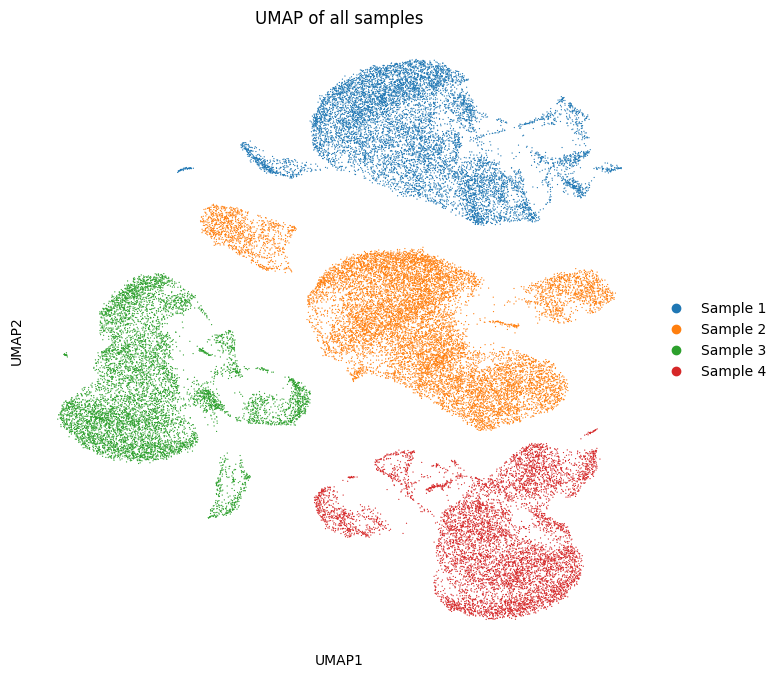

In [17]:
adata_corr_umap3 = calc_umap(adata_corrected)
plot_umap(adata_corr_umap3)

# Batch effects correction - scanpy MNN correct

In [ ]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X
adata_mnn_corrected, corrected_batches = mnn_correct(*adata_list, batch_key='batch')
# after = adata_combined.X
after = adata_corrected.X
print((before != after).sum())  # Count changes
adata_corr_umap3 = calc_umap(adata_corrected)
plot_umap(adata_corr_umap3)

# Batch effects correction - scanpy pycombat - no normalisation

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


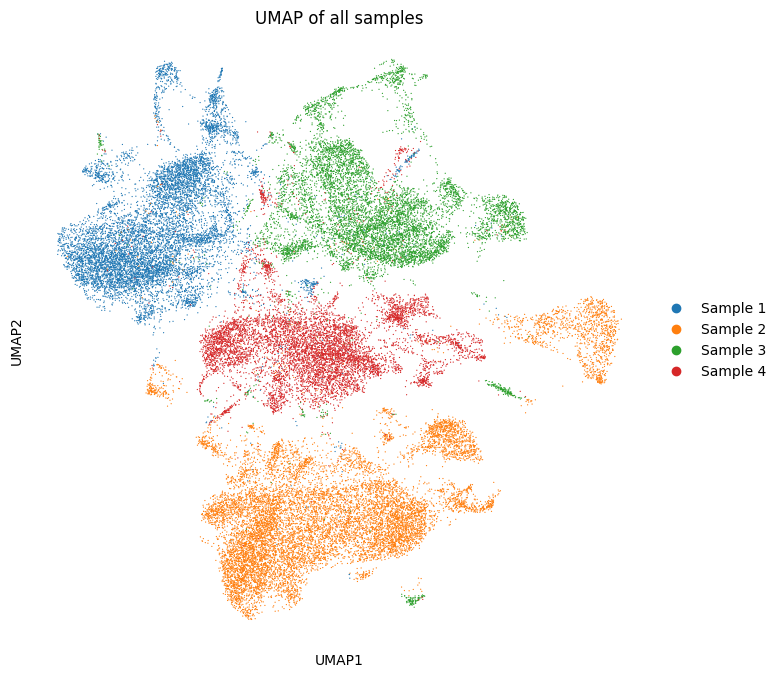

In [25]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]
adata_corrected = adata_combined.copy()
sc.pp.combat(adata_corrected, key='sample', inplace=True)
adata_corr_umap = calc_umap(adata_corrected)
plot_umap(adata_corr_umap)

# Batch effects correction - scanpy pycombat - with normalisation

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


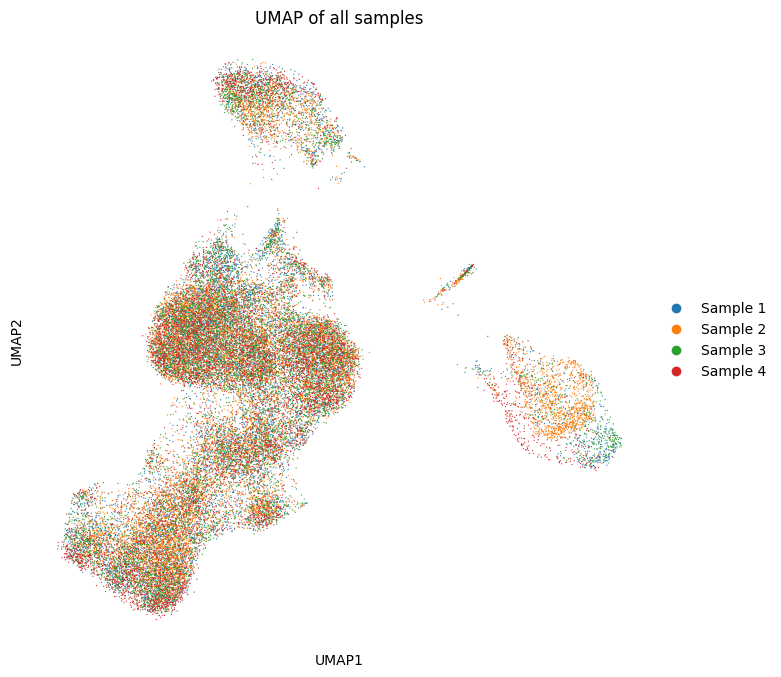

In [13]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')
# Normalize and log-transform the raw counts
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]
adata_corrected = adata_combined.copy()
sc.pp.combat(adata_corrected, key='sample', inplace=True)
adata_corr_umap = calc_umap(adata_corrected.copy())
plot_umap(adata_corr_umap)
adata_umap.write_h5ad('../data/merged_batch_corrected.h5ad', compression='gzip')

In [19]:
merged_adata.obs['predicted.celltype'].unique()

['CD4+ T cell', 'Cytotoxic T cell', 'B cell', 'CD14+ monocyte', 'Natural killer cell', 'Megakaryocyte', 'Plasmacytoid dendritic cell']
Categories (7, object): ['B cell', 'CD4+ T cell', 'CD14+ monocyte', 'Cytotoxic T cell', 'Megakaryocyte', 'Natural killer cell', 'Plasmacytoid dendritic cell']

# Differential expression

In [30]:
cell_type_count_dict['sample_1'].most_common(1)[0][1]

5410

In [38]:
cell_type_count_dict = {} # Used for penalizing pval adj
for i, sample in enumerate(samples):
    cnt = Counter(adata_list[0].obs['predicted.celltype'])
    cell_type_count_dict[sample] = cnt
    
# Subset for the four cell types of interest
cell_types = ['B cell', 'CD14+ monocyte', 'CD4+ T cell', 'Cytotoxic T cell', 'Natural killer cell']
adata_subset = merged_adata[merged_adata.obs['predicted.celltype'].isin(cell_types)].copy()

# Perform DE analysis for each cell type
results_all_degs = {ct: dict() for ct in cell_types}
results_significant_degs = {ct: dict() for ct in cell_types}
results_top_degs = {ct: dict() for ct in cell_types}
for cell_type in cell_types:
    cell_type_data = adata_subset[adata_subset.obs['predicted.celltype'] == cell_type]
    for sample in ['sample_1', 'sample_2', 'sample_3']:

        cell_type_data_sample = cell_type_data[cell_type_data.obs['sample'].isin([sample, 'sample_4'])]
        # sample_size = len(cell_type_data_sample[cell_type_data_sample.obs['sample'] == sample])
    
        # Perform DE analysis
        sc.tl.rank_genes_groups(cell_type_data_sample, groupby='sample', reference='sample_4', method='wilcoxon', pts=True)
    
        # Store results
        # Filter genes with significant adjusted p-value
        degs_df = sc.get.rank_genes_groups_df(cell_type_data_sample, group=sample)
        # Add penalty depending on the number of cells: 
        
        degs_df.loc[:, 'pvals_adj_weighted'] = degs_df['pvals_adj'] * np.sqrt(cell_type_count_dict[sample].most_common(1)[0][1]) / \
            np.sqrt(cell_type_count_dict[sample][cell_type]) 
        significant_degs = degs_df[degs_df['pvals_adj_weighted'] < 0.05]  # Adjust threshold as needed
        significant_degs = significant_degs[~significant_degs['logfoldchanges'].isna()]
        significant_degs.loc[:, 'logfoldchanges_abs'] = significant_degs['logfoldchanges'].apply(abs)
        significant_degs = significant_degs.sort_values(by='logfoldchanges_abs', ascending=False) # Sort by log fold change or adjusted p-value
        top_degs = significant_degs[(significant_degs['logfoldchanges_abs'] > 1) ]

        results_all_degs[cell_type][sample] = degs_df
        results_significant_degs[cell_type][sample] = significant_degs
        results_top_degs[cell_type][sample] = top_degs
        print(len(significant_degs), len(top_degs))

# Save results
# for cell_type, df in results.items():
#     df.to_csv(f"DE_genes_{cell_type.replace(' ', '_')}.csv", index=False)

# print("Differentially expressed genes saved for each cell type.")


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


1658 266


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


2365 196


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


949 89


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


822 261


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


1124 366


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


705 410


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


6714 136


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


7157 173


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


4066 26


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


3236 131


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


4655 547


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


1561 140


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


3 2


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


192 29
1 1


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [39]:
# Check differentially expressed genes inside control (just for sanity)
# adata_subset = adata_corrected[adata_corrected.obs['predicted.celltype'].isin(['B cell'])].copy()
# adata_subset = adata_subset[adata_subset.obs['sample'].isin(['sample_4'])]
# np.random.seed(488)
# adata_subset.obs.loc[:, 'half'] = [str(x) for x in np.random.randint(0, 2, size=(len(adata_subset)))]

# sc.tl.rank_genes_groups(adata_subset, groupby='half', reference='1', method='wilcoxon')

# degs_df = sc.get.rank_genes_groups_df(adata_subset, group='0')
# significant_degs = degs_df[degs_df['pvals_adj'] < 0.05]  # Adjust threshold as needed
# significant_degs = significant_degs[~significant_degs['logfoldchanges'].isna()]
# significant_degs = significant_degs[significant_degs['logfoldchanges'] > 1]

# # Sort by log fold change or adjusted p-value
# top_degs = significant_degs.sort_values(by='logfoldchanges', ascending=False)
# top_degs

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


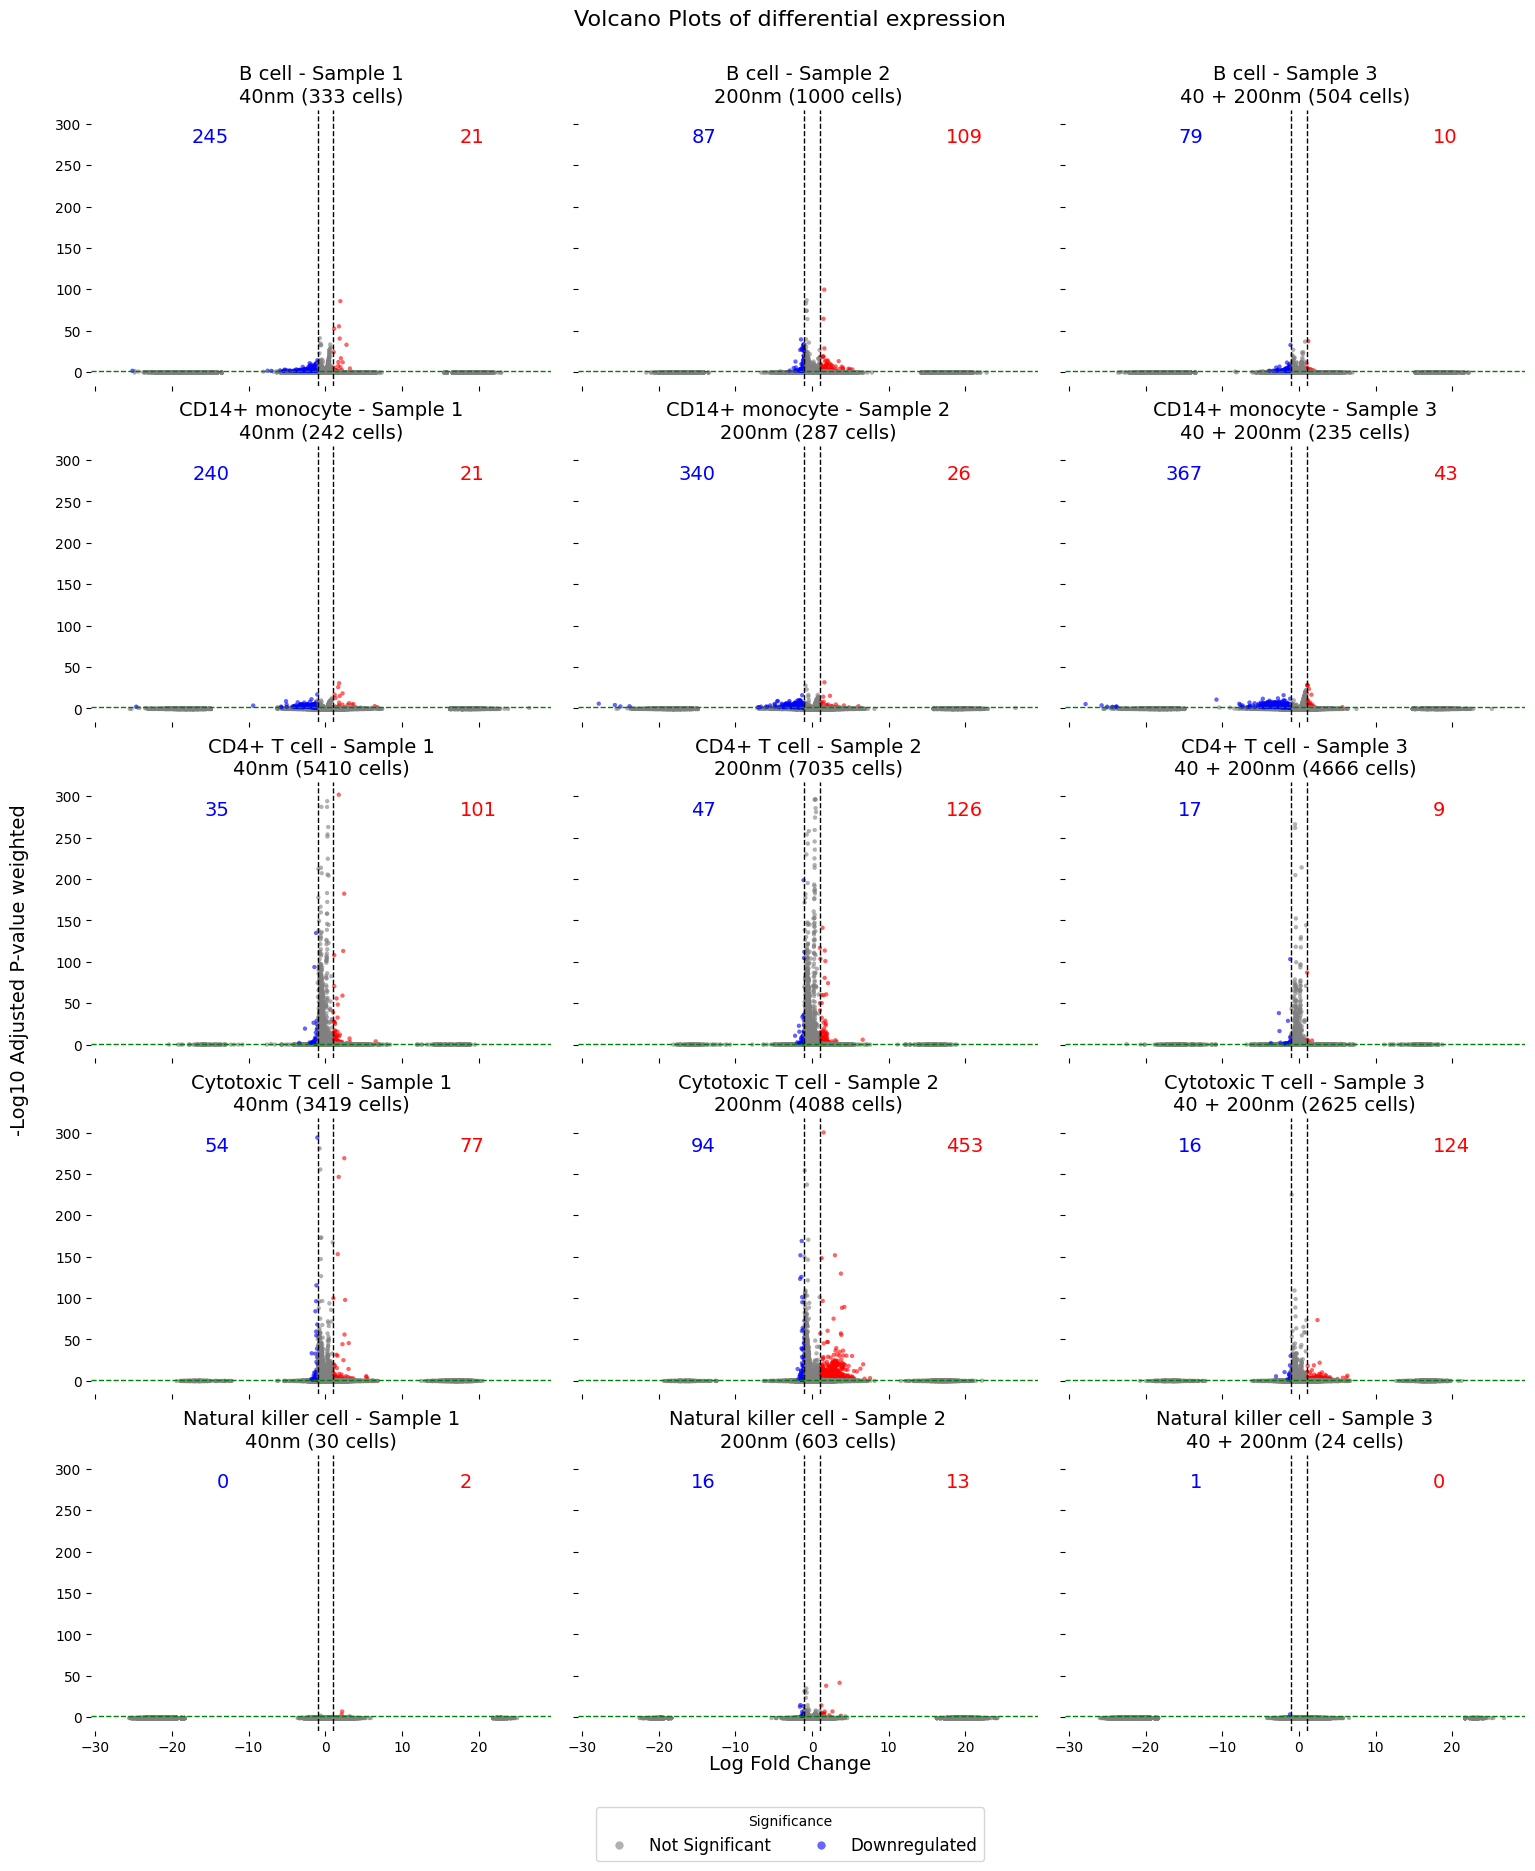

In [46]:
# Define thresholds for significant DEGs
logFC_threshold = 1
adj_p_value_threshold = 0.05

# Data structure keys
cell_types = list(results_all_degs.keys())
samples_desc = ['Sample 1\n40nm', 'Sample 2\n200nm', 'Sample 3\n40 + 200nm']

# Create a grid of subplots based on the dimensions of the data
n_rows = len(cell_types)
n_cols = len(samples_desc)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True, sharey=True)

# Iterate through cell types and samples
for i, cell_type in enumerate(cell_types):
    for j, sample in enumerate(samples_desc):
        ax = axes[i, j]
        
        # Access the dataframe for the current cell type and sample
        df = results_all_degs[cell_type][f"sample_{j + 1}"]
        
        # Add a column to classify genes based on thresholds
        df['significance'] = 'Not Significant'
        df.loc[(df['logfoldchanges'] >= logFC_threshold) & (df['pvals_adj_weighted'] < adj_p_value_threshold), 'significance'] = 'Upregulated'
        df.loc[(df['logfoldchanges'] <= -logFC_threshold) & (df['pvals_adj_weighted'] < adj_p_value_threshold), 'significance'] = 'Downregulated'

        
        # Create the volcano plot for this subplot
        sns.scatterplot(
            data=df,
            x='logfoldchanges', 
            y=-np.log10(df['pvals_adj_weighted']), 
            hue='significance',
            palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'},
            alpha=0.6,
            s=8,
            edgecolor=None,
            ax=ax
        )
        
        # Add threshold lines
        ax.axvline(x=logFC_threshold, color='black', linestyle='--', linewidth=1)
        ax.axvline(x=-logFC_threshold, color='black', linestyle='--', linewidth=1)
        ax.axhline(y=-np.log10(adj_p_value_threshold), color='green', linestyle='--', linewidth=1)
        
        # Set subplot title to include current cell type and sample
        num_cells = len(adata_list[j][adata_list[j].obs['predicted.celltype'] == cell_type])
        ax.set_title(f"{cell_type} - {sample} ({num_cells} cells)", fontsize=14)
        ax.get_legend().remove()
        
        # Remove x and y labels for subplots
        ax.set_xlabel("")
        ax.set_ylabel("")

        # Remove frame around each subplot
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        
        # Annotate the number of upregulated and downregulated genes
        # Count the number of upregulated and downregulated genes
        upregulated_count = df[df['significance'] == 'Upregulated'].shape[0]
        downregulated_count = df[df['significance'] == 'Downregulated'].shape[0]
        ax.text(
            0.3, 0.9, f"{downregulated_count}", 
            color='blue', va='center', ha='right', fontsize=14,
            transform=ax.transAxes  # Use axes coordinates for consistent positioning
        )
        ax.text(
            0.8, 0.9, f"{upregulated_count}", 
            color='red', va='center', ha='left', fontsize=14,
            transform=ax.transAxes  # Use axes coordinates for consistent positioning
        )

# Add main x and y labels with adjusted positions
fig.text(0.5, 0.1, 'Log Fold Change', ha='center', fontsize=14)
fig.text(-0.02, 0.5, '-Log10 Adjusted P-value weighted', va='center', rotation='vertical', fontsize=14)

# Adjust layout and add a single legend below the figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Significance', loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 0.05), markerscale=2)

plt.tight_layout(rect=[0, 0.1, 1, 0.96])  # Adjust lower space for legend
plt.suptitle("Volcano Plots of differential expression", fontsize=16)
plt.savefig(f'volcano.png', dpi=200, bbox_inches='tight')
plt.show()


2449


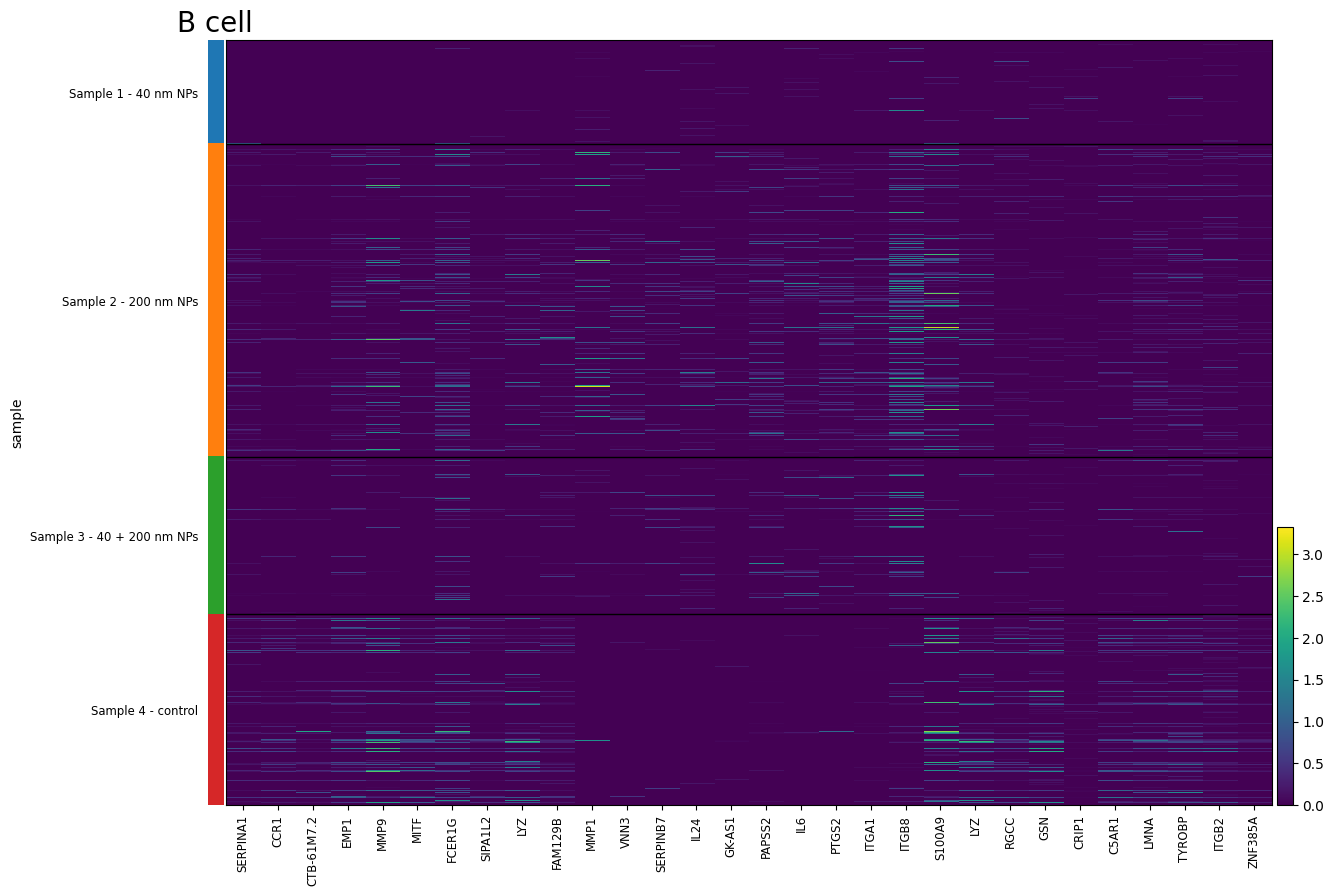

996


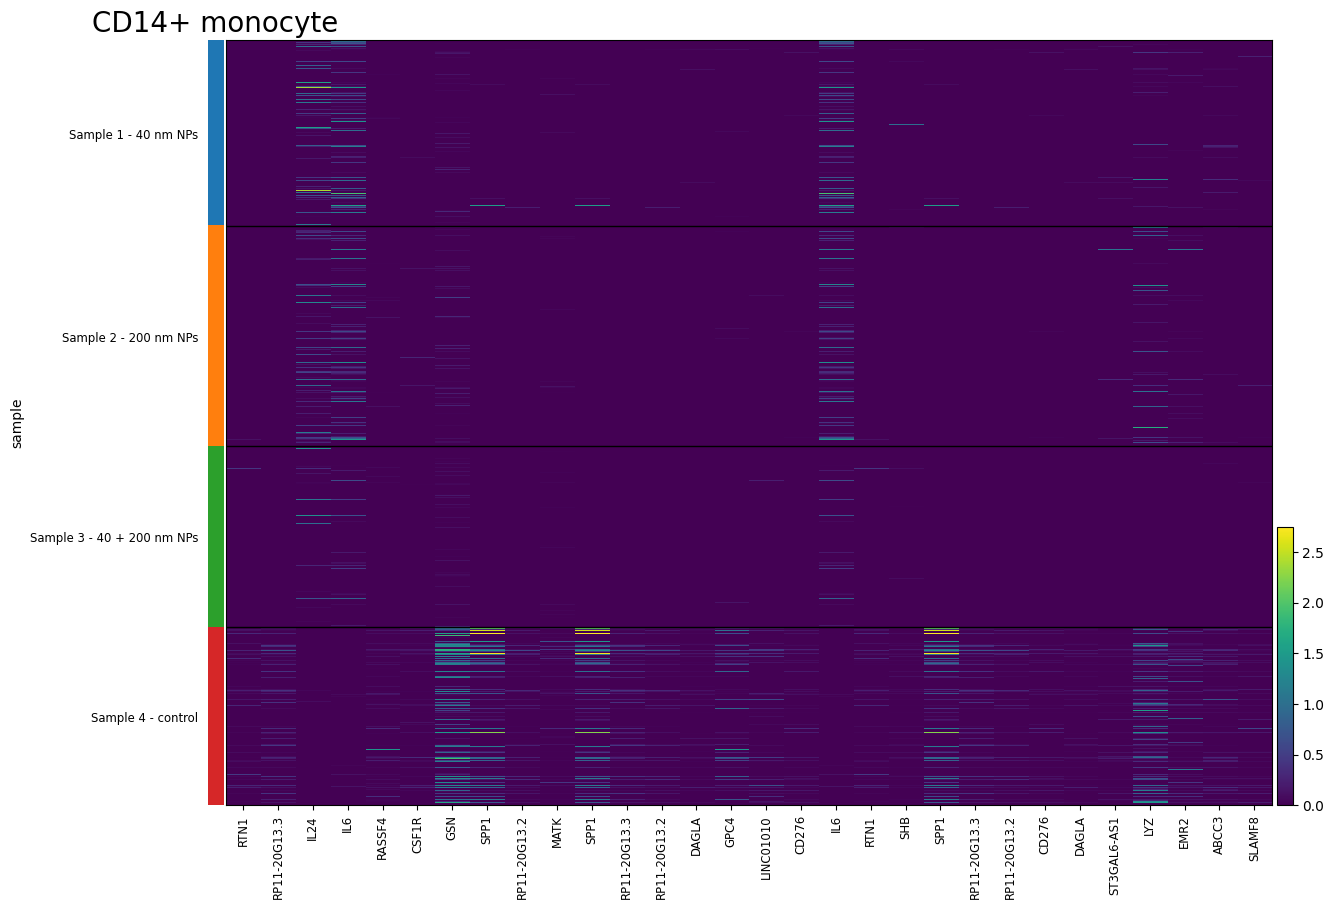

21564


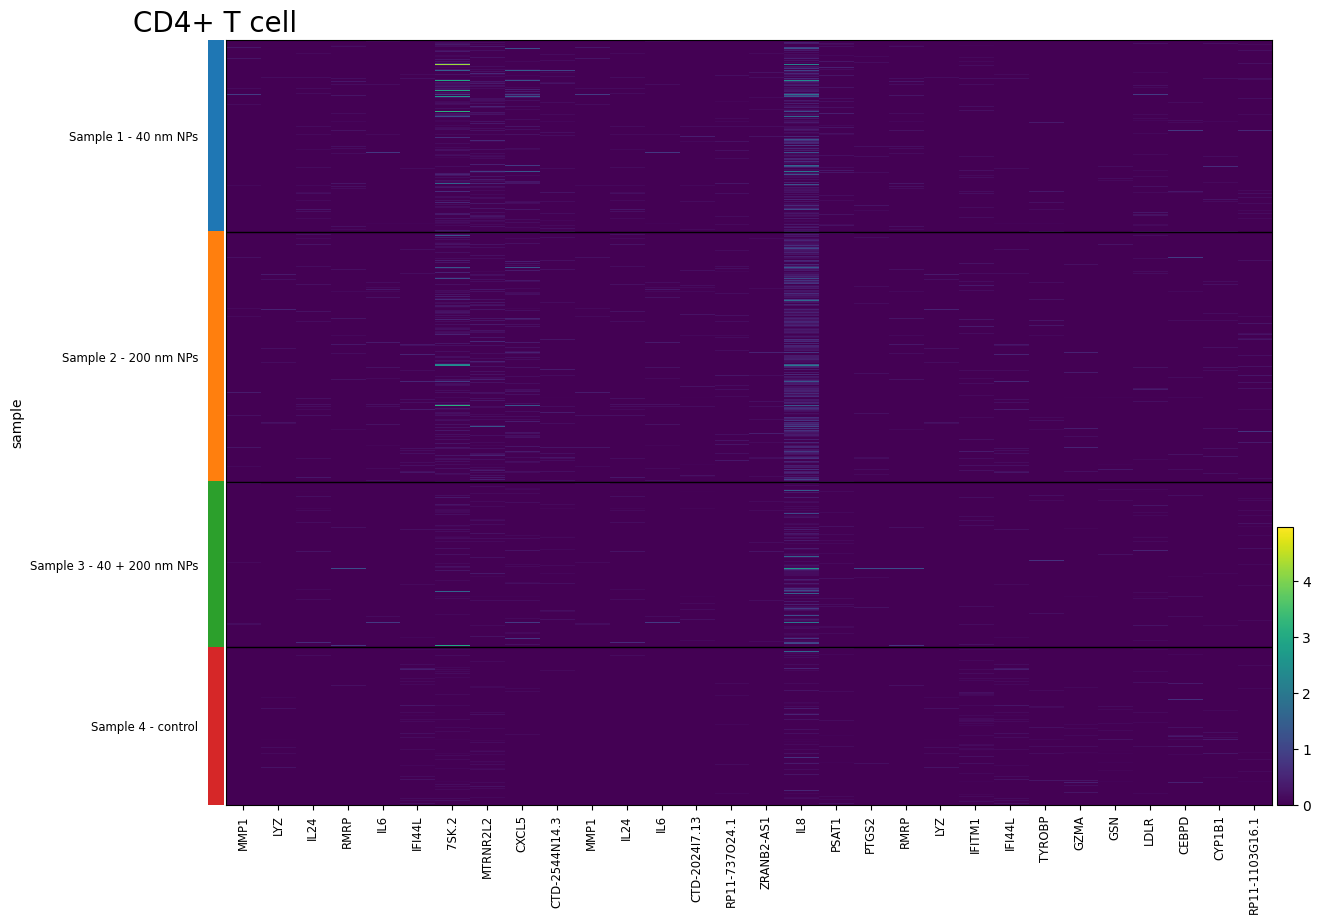

12202


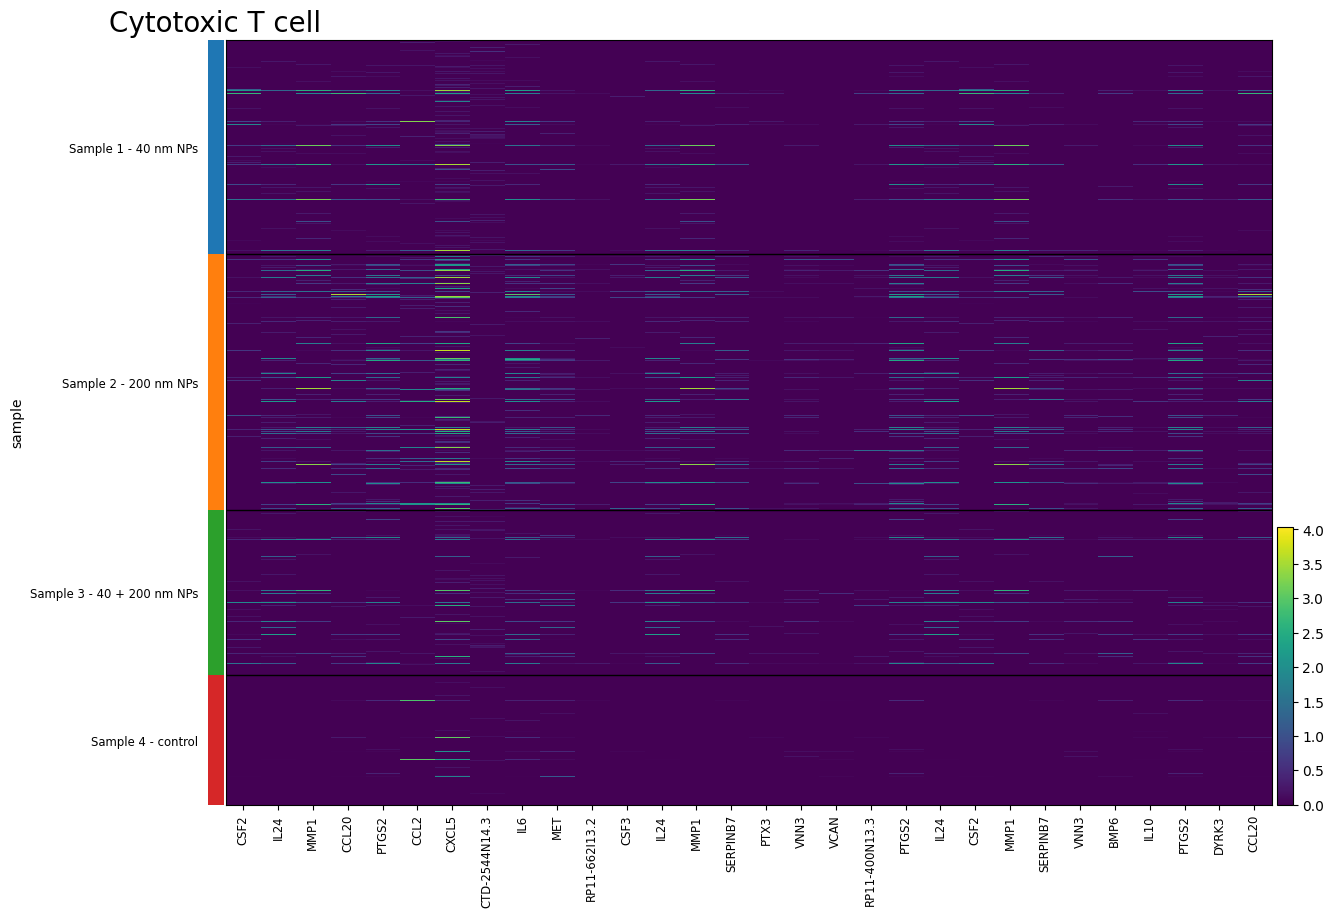

821


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [47]:
# Create a figure for each cell type
# fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns for 4 subplots
# axes = axes.flatten()  # Flatten the 2x2 array into a 1D array for easier indexing
sample_names_dict = dict(zip(samples, sample_names))
# Loop through each cell type and plot in a subplot
for i, ct in enumerate(cell_types):
    # fig, axes = plt.subplots(1, 1, figsize=(14, 10))  # 2 rows, 2 columns for 4 subplots
    adata_subset = merged_adata[merged_adata.obs['predicted.celltype'].isin([ct])].copy()
    adata_subset.obs['sample'] = [sample_names_dict[sample] for sample in adata_subset.obs['sample']]
    print(len(adata_subset))

    # Plot heatmap for top genes
    top_genes_all = np.array([results_significant_degs[ct][sample].head(10)['names'] for sample in samples[:-1]]).flatten()
    sc.pl.heatmap(
        adata_subset, 
        var_names=top_genes_all,
        groupby='sample', 
        use_raw=False,
        figsize=(14, 10),
        show=False,  # Prevent automatic display
    )
    plt.title(ct, fontsize = 20)
    plt.savefig(f'heatmap_{ct}.png', dpi=150, bbox_inches='tight')
    plt.show()
    # axes[i].set_title(ct)  # Set the title for each subplot

# Adjust layout for better spacing
plt.tight_layout()

In [ ]:
for i, ct in enumerate(cell_types):
    for sample in ['sample_1', 'sample_2', 'sample_3']:
        display(results_significant_degs[ct][sample].head(10))

In [ ]:
for i, ct in enumerate(cell_types):
    for sample in ['sample_1', 'sample_2', 'sample_3']:
        df = results_significant_degs[ct][sample]
        display(df[df['logfoldchanges_abs'] > 1])